# **Graph Neural Networks for Particle Momentum Estimation in the CMS Trigger System Task-2**

## Installing Requirements

In [1]:
pip install energyflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.5/700.5 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.0/503.0 KB 29.5 MB/s eta 0:00:00


In [2]:
!pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 24.6 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=96e464ddc1fb44d1b8a062591e827dd90584bfa68366d20d013848df6d6dd62f
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built 

## Importing Libraries

In [1]:
import energyflow
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, f1_score, accuracy_score, roc_curve
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, Linear, global_mean_pool, GraphConv, global_max_pool
import torch.nn.functional as F

## Extracting Data

Downloading data using energyflow library

In [3]:
data = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',
                        with_bc=False, cache_dir='~/.energyflow')

In [4]:
# Tuple unpacking
X, y = data

Getting the shape of the dataset. 
X is a matrix of size (N, M, 4) where,


1. N is the number of jets <br>
2. M is the maximum particles in a jet <br>
3. 4 are the features of each particles denoting (pt, eta, phi, pid) values. <br>



In [5]:
print(f'X Shape : {X.shape}')

X Shape : (100000, 139, 4)


In [6]:
# Checking Distribution of Labels
print(f'Division of labels : {np.unique(y, return_counts = True)}')

Division of labels : (array([0., 1.]), array([50000, 50000]))


## Constructing Graphs

The graphs for ech jet is constructed in the following way: 

1. First for each jet we remove all the particles having all features values were zero i.e., remove paddings.

2. Next we calculate the pair-wise euclidean distance between the nodes using this metric,

<center>
$R = \sqrt{Δη^2 + Δϕ^2}$
</center>

I have set a threshold for R above which we do not consider an edge between the nodes. The chosen value after experimenting is **0.05**.

3. Next, edge-index are formed and the reverse edges are also concatenated. 

4. R values are set as the edge-weights and all the 4 feature are set as the node-features.

In [7]:
class JetGraphDataset(Dataset):

    def __init__(self, jet_graphs, jet_labels, split = 'train', seed = 1, split_ratio = 0.2, edge_threshold = 0.05):

        jet_graphs = torch.from_numpy(jet_graphs).float()
        jet_labels = torch.from_numpy(jet_labels).long()

        self.edge_threshold = edge_threshold

        # Splitting the data into train-val-test graphs
        X_train, X_rem, Y_train, Y_rem = train_test_split(jet_graphs, jet_labels, test_size = split_ratio, stratify = jet_labels, random_state = seed)
        X_val, X_test, Y_val, Y_test = train_test_split(X_rem, Y_rem, train_size = 0.5, stratify = Y_rem, random_state = seed)

        if split == 'train':
          self.graphs = X_train
          self.labels = Y_train

        elif split == 'test':
          self.graphs = X_test
          self.labels = Y_test

        else:
          self.graphs = X_val
          self.labels = Y_val
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):

        jet_graph = self.construct_jet_graph(self.graphs[idx])
        jet_graph.y = self.labels[idx]

        #print('final : ', jet_graph.x.shape, jet_graph.edge_index.shape, jet_graph.edge_attr.shape, jet_graph.y.shape)

        return jet_graph

    def construct_jet_graph(self, jet_matrix):

        # Discard rows with all values as 0
        jet_matrix = jet_matrix[~(jet_matrix == 0).all(1)]

        # Calculate pairwise euclidean distances between rows
        euclidean_distances = torch.cdist(jet_matrix[:, 1:3], jet_matrix[:, 1:3], p=2)

        # Create edge indices based on the distance threshold
        edge_indices = torch.nonzero(euclidean_distances <= self.edge_threshold)
        #print('indices', edge_indices.shape)
        edge_indices = edge_indices.t().contiguous()
        edge_indices = torch.cat((edge_indices, edge_indices[[1, 0]]), dim=1)

        # Create node features and edge features
        x = jet_matrix[:, [0, 1, 2, 3]]
        edge_attr = euclidean_distances[edge_indices[0], edge_indices[1]].unsqueeze(-1)

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_indices, edge_attr=edge_attr)

        return data

In [8]:
# Creating the train-val-test datasets

train_dataset = JetGraphDataset(X, y, split = 'train', edge_threshold = 0.05)
val_dataset = JetGraphDataset(X, y, split = 'val', edge_threshold = 0.05)
test_dataset = JetGraphDataset(X, y, split = 'test', edge_threshold = 0.05)

## DataLoaders

In [9]:
def get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):

    """
    Function to create the DataLoaders for train-val-test data. 
    Can specify batch size. Default value is set to 32.
    """

    # Shuffle=True for training data to get diversity in batches at each training epoch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32)

### Set Device

In [10]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
device = get_device()
print(device)

cpu


#Model

### Model Architecture

I haved used 2 GNN architectures


**Architecture 1**

1. 3-layer GCN network with relu for aggregation of node-level features.
2. Readput layer as global mean pooling for graph-level embedding.
3. A dropout layer followed by linear layer.

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, node_features = 2, hidden_channels = 16, num_classes = 2):

        super(GCN, self).__init__()
        torch.manual_seed(1)

        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_attr)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

**Architecture 2**

1. Use of GraphConv layer in-place of GCN layer. It adds skip connections in the network tp preserve central node information and omits neighborhood normalization completely.

2. The same readout layer with gloab_mean_pooling is used. I also tried using a combination of global_mean and global_max pool but it lead to decrease in performance.

3. This is followed by an additional linear layer with relu. Then a dropout and final linear layer.

In [13]:
class GraphNN(torch.nn.Module):
    def __init__(self, node_features = 2, hidden_channels = 16, num_classes = 2):

        super(GraphNN, self).__init__()
        torch.manual_seed(1)

        self.conv1 = GraphConv(node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)

        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, num_classes)


    def forward(self, data):

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Neighbourhood node-feature aggregation
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_attr)

        #x_max = global_max_pool(x, batch)
        #x_mean = global_mean_pool(x, batch)
        #x = torch.cat([x_max, x_mean], dim=1)

        # Batch-wise node-level aggreation 
        x = global_mean_pool(x, batch)  # (batch, features)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)

        return x

In [14]:
model_GCN = GCN(node_features = 4, hidden_channels = 16, num_classes = 2)
model_GraphNN = GraphNN(node_features = 4, hidden_channels = 16, num_classes = 2)

model_GCN = model_GCN.to(device)
model_GraphNN = model_GraphNN.to(device)

In [15]:
print(model_GCN)

GCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


In [16]:
print(model_GraphNN)

GraphNN(
  (conv1): GraphConv(4, 16)
  (conv2): GraphConv(16, 16)
  (conv3): GraphConv(16, 16)
  (lin1): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [17]:
# Defining the optimizer and loss function

optimizer_GCN = torch.optim.Adam(model_GCN.parameters(), lr=0.001)
optimizer_GraphNN = torch.optim.Adam(model_GraphNN.parameters(), lr=0.001)

criterion = torch.nn.CrossEntropyLoss()

### Defining Train-Val-Test Functions

In [18]:
def train(model, device, loader, optimizer, criterion):

    model.train()
    correct = 0
    total_loss = 0
    for data in tqdm(loader):  # Iterate in batches over the training dataset.
        
        data = data.to(device)

        out = model(data)  # Perform a single forward pass.

        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        pred = out.argmax(dim=1)

        correct += int((pred == data.y).sum())
        total_loss += loss.item()

    print(f'Train Acc: {correct/len(loader.dataset):.3f}, Train Loss: {total_loss:.4f}')

    return model, total_loss

    
def evaluate(model, device, loader):
  
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for data in tqdm(loader):

            data = data.to(device)
            out = model(data)

            # Calculation of correctly classified edges
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()

        print(f'Val Acc : {correct/len(loader.dataset):.3f}\n')

### Training

In [19]:
# Training Loop for Architecture 1

epochs = 10

for epoch in range(epochs):

  print(f'Epoch : {epoch+1} \n')

  model_GCN, loss = train(model_GCN, device, train_loader, optimizer_GCN, criterion)
  evaluate(model_GCN, device, val_loader)

Epoch : 1 



100%|██████████| 2500/2500 [01:51<00:00, 22.49it/s]


Train Acc: 0.700, Train Loss: 1479.4574


100%|██████████| 313/313 [00:10<00:00, 30.26it/s]


Val Acc : 0.760

Epoch : 2 



100%|██████████| 2500/2500 [01:40<00:00, 24.85it/s]


Train Acc: 0.748, Train Loss: 1308.6267


100%|██████████| 313/313 [00:09<00:00, 34.11it/s]


Val Acc : 0.764

Epoch : 3 



100%|██████████| 2500/2500 [01:40<00:00, 24.92it/s]


Train Acc: 0.755, Train Loss: 1288.9206


100%|██████████| 313/313 [00:10<00:00, 30.16it/s]


Val Acc : 0.767

Epoch : 4 



100%|██████████| 2500/2500 [01:43<00:00, 24.17it/s]


Train Acc: 0.760, Train Loss: 1278.3362


100%|██████████| 313/313 [00:08<00:00, 35.57it/s]


Val Acc : 0.773

Epoch : 5 



100%|██████████| 2500/2500 [01:42<00:00, 24.38it/s]


Train Acc: 0.760, Train Loss: 1272.5268


100%|██████████| 313/313 [00:09<00:00, 34.19it/s]


Val Acc : 0.768

Epoch : 6 



100%|██████████| 2500/2500 [01:39<00:00, 25.11it/s]


Train Acc: 0.762, Train Loss: 1267.4016


100%|██████████| 313/313 [00:09<00:00, 34.50it/s]


Val Acc : 0.773

Epoch : 7 



100%|██████████| 2500/2500 [01:45<00:00, 23.66it/s]


Train Acc: 0.764, Train Loss: 1266.0319


100%|██████████| 313/313 [00:09<00:00, 34.40it/s]


Val Acc : 0.770

Epoch : 8 



100%|██████████| 2500/2500 [02:06<00:00, 19.75it/s]


Train Acc: 0.765, Train Loss: 1261.8620


100%|██████████| 313/313 [00:08<00:00, 35.62it/s]


Val Acc : 0.771

Epoch : 9 



100%|██████████| 2500/2500 [01:50<00:00, 22.65it/s]


Train Acc: 0.767, Train Loss: 1258.8274


100%|██████████| 313/313 [00:09<00:00, 33.47it/s]


Val Acc : 0.771

Epoch : 10 



100%|██████████| 2500/2500 [01:47<00:00, 23.23it/s]


Train Acc: 0.767, Train Loss: 1258.1549


100%|██████████| 313/313 [00:09<00:00, 32.50it/s]

Val Acc : 0.772



In [20]:
# Training Loop for Architecture 2

epochs = 10

for epoch in range(epochs):

  print(f'Epoch : {epoch+1} \n')

  model_GraphNN, loss = train(model_GraphNN, device, train_loader, optimizer_GraphNN, criterion)
  evaluate(model_GraphNN, device, val_loader)

Epoch : 1 



100%|██████████| 2500/2500 [01:22<00:00, 30.36it/s]


Train Acc: 0.737, Train Loss: 1372.5108


100%|██████████| 313/313 [00:06<00:00, 45.46it/s]


Val Acc : 0.781

Epoch : 2 



100%|██████████| 2500/2500 [01:22<00:00, 30.13it/s]


Train Acc: 0.769, Train Loss: 1262.0039


100%|██████████| 313/313 [00:06<00:00, 48.15it/s]


Val Acc : 0.785

Epoch : 3 



100%|██████████| 2500/2500 [01:23<00:00, 29.97it/s]


Train Acc: 0.779, Train Loss: 1232.8763


100%|██████████| 313/313 [00:07<00:00, 39.37it/s]


Val Acc : 0.787

Epoch : 4 



100%|██████████| 2500/2500 [01:24<00:00, 29.44it/s]


Train Acc: 0.784, Train Loss: 1215.3112


100%|██████████| 313/313 [00:07<00:00, 39.81it/s]


Val Acc : 0.791

Epoch : 5 



100%|██████████| 2500/2500 [01:37<00:00, 25.55it/s]


Train Acc: 0.785, Train Loss: 1210.4889


100%|██████████| 313/313 [00:07<00:00, 39.73it/s]


Val Acc : 0.786

Epoch : 6 



100%|██████████| 2500/2500 [01:28<00:00, 28.14it/s]


Train Acc: 0.786, Train Loss: 1203.9970


100%|██████████| 313/313 [00:07<00:00, 39.99it/s]


Val Acc : 0.791

Epoch : 7 



100%|██████████| 2500/2500 [01:25<00:00, 29.19it/s]


Train Acc: 0.786, Train Loss: 1200.0282


100%|██████████| 313/313 [00:07<00:00, 42.83it/s]


Val Acc : 0.788

Epoch : 8 



100%|██████████| 2500/2500 [01:27<00:00, 28.73it/s]


Train Acc: 0.788, Train Loss: 1193.1311


100%|██████████| 313/313 [00:07<00:00, 44.28it/s]


Val Acc : 0.788

Epoch : 9 



100%|██████████| 2500/2500 [01:25<00:00, 29.10it/s]


Train Acc: 0.788, Train Loss: 1197.1163


100%|██████████| 313/313 [00:06<00:00, 47.42it/s]


Val Acc : 0.790

Epoch : 10 



100%|██████████| 2500/2500 [01:28<00:00, 28.31it/s]


Train Acc: 0.789, Train Loss: 1196.4977


100%|██████████| 313/313 [00:07<00:00, 41.29it/s]

Val Acc : 0.795



### Testing

In [21]:
def test(model, device, loader):
  
    model.eval()
    y_true = []
    y_probas = []
    y_pred = []

    with torch.no_grad():
      
        for data in tqdm(loader):
          
            data = data.to(device)
            out = model(data)
            
            y_true += data.y.cpu().numpy().tolist()
            y_pred += out.argmax(dim=1).cpu().numpy().tolist()  # absoulte predictions
            y_probas += out[:, 1].cpu().numpy().tolist()  # probability of class 1

    # Calculating few metrics

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_probas)
    roc_auc = auc(fpr, tpr)

    print('\nResults\n')
    print(f'Testing Accuracy {acc:.3f}')
    print(f'F1 score: {f1:.3f}')
    print(f'ROC-AUC: {roc_auc:.3f}\n')

    return acc, f1, fpr, tpr, roc_auc

In [24]:
# Testing Architecture 1

acc, f1, fpr1, tpr1, area1 = test(model_GCN, device, test_loader)

100%|██████████| 313/313 [00:16<00:00, 18.49it/s]


Results

Testing Accuracy 0.768
F1 score: 0.762
ROC-AUC: 0.841



In [25]:
# Testing Architecture 2

acc, f1, fpr2, tpr2, area2 = test(model_GraphNN, device, test_loader)

100%|██████████| 313/313 [00:15<00:00, 19.59it/s]


Results

Testing Accuracy 0.792
F1 score: 0.788
ROC-AUC: 0.872



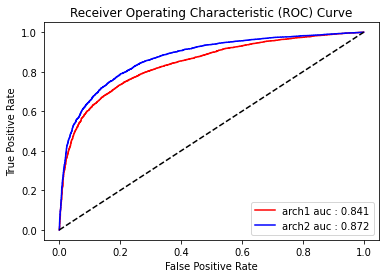

In [27]:
plt.plot(fpr1, tpr1, color = 'red', label = f'arch1 auc : {area1:.3f}')
plt.plot(fpr2, tpr2, color = 'blue', label = f'arch2 auc : {area2:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.savefig(f'roc_auc.png')
plt.show()